In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from os import path as op
import nibabel as nb
import numpy as np
from scipy.stats import zscore
from mriqc.interfaces.functional import auto_mask, find_spikes
from mriqc.interfaces.functional import Spikes
import matplotlib.pyplot as plt
from mriqc.interfaces.viz_utils import plot_mosaic

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
bids_dir = op.expanduser('~/Data/example_artifacts_dataset')
sub_id = '51205'
func_name = op.join(bids_dir, 'sub-ben01/func/sub-ben01_task-unknown_bold.nii.gz')
#func_name = op.abspath('./example_artifacts_dataset/sub-arielle01/func/sub-arielle01_task-unknown_bold.nii.gz')
#func_name = op.abspath('./example_artifacts_dataset/sub-ds001s07/func/sub-ds001s07_task-balloonanalogrisktask_run-03_bold.nii.gz')
#func_name = op.abspath('./example_artifacts_dataset/sub-steph02/func/sub-steph02_task-unknown_bold.nii.gz')

# mask_name = op.join('./data/sub-ben01_task-unknown_bold_mask.nii.gz')
#func_name = './example_artifacts_dataset/sub-{0}/func/sub-{0}_task-rest_bold.nii.gz'.format(sub_id)
#mask_name = op.abspath('./data/sub-{}_task-rest_bold_mcf_mask.nii.gz'.format(sub_id))
ntsteps = nb.load(func_name).get_data().shape[-1]

/home/oesteban/workspace/mriqc/mriqc/workflows/utils.py:145: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ftmask[size[0]/2, size[1]/2] = 0


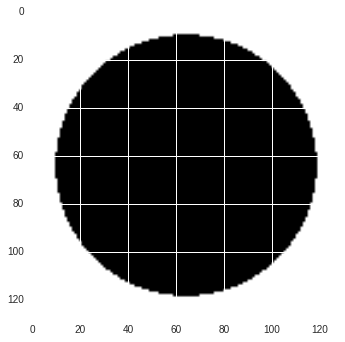

In [4]:
from mriqc.workflows.utils import spectrum_mask
dshape = nb.load(func_name).get_data().shape
ftmask = spectrum_mask((dshape[0], dshape[1]))
plt.imshow(ftmask)

In [46]:
from mriqc.workflows.utils import slice_wise_fft

fft_fname, spikes_file = slice_wise_fft(func_name, ftmask, spike_thres=10)

In [50]:
new = np.loadtxt(spikes_file)

print set([tuple(n) for n in new]) - set([tuple(o) for o in old])

set([(18.0, 0.0), (9.0, 15.0), (27.0, 18.0), (18.0, 7.0), (12.0, 31.0), (12.0, 2.0), (31.0, 0.0), (22.0, 0.0)])


In [40]:
from statsmodels.robust.scale import mad
fft_nii = nb.load(fft_fname)
fft_data = fft_nii.get_data()
mu = np.median(fft_data, axis=3)
sigma = np.stack([mad(fft_data, axis=3)] * fft_data.shape[-1], -1)

idxs = np.where(np.abs(sigma) > 1e-4)
fft_zscored = fft_data - mu[..., np.newaxis]
fft_zscored[idxs] /= sigma[idxs]
nb.Nifti1Image(fft_zscored, fft_nii.get_affine(), fft_nii.get_header()).to_filename('fft_zscored.nii.gz')

(128, 128, 33, 33)


In [8]:
from mriqc.interfaces.viz_utils import (plot_mosaic_helper, plot_fd, plot_segmentation)

fft_data = nb.load(fft_nii)
fft_data += 
plot_mosaic_helper(fft_nii, 'ben01', '0', '0', 'plot.svg')

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nibabel-2.0.2-py2.7.egg/nibabel/orientations.py:223: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  undo_reorder = np.eye(p + 1)[list(ornt[:, 0]) + [p], :]


TypeError: Invalid dimensions for image data

In [6]:
from mriqc.viz.fmriplots import fMRIPlot
myplot = fMRIPlot(func_name)
myplot.add_spikes(np.loadtxt(spikes_file), 'Spikes (brainmask)')
#myplot.add_spikes(res2.outputs.out_tsz, 'Spikes (chrismask)')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'FD')
myplot.plot()

TypeError: __init__() takes at least 3 arguments (2 given)

In [36]:
sp_if = Spikes(in_file=func_name, in_mask=mask_name, out_tsz='brain.txt')
res = sp_if.run()

sp_if2 = Spikes(in_file=func_name, automask='chris', out_tsz='chris.txt', no_zscore=False)
res2 = sp_if2.run()

NameError: name 'mask_name' is not defined